# Updated Finsler Fire Spread Model (Deterministic, Time‑Aware)

Compatible with the **new deterministic Finsler model** (`fire_model/finsler.py`).

This notebook demonstrates:
- Environment setup (fuel, value, wind, ROS)
- Deterministic Finsler arrival-time evolution
- Retardant drops and **retardant half‑life decay**
- Fire boundary extraction (isochrone boundary)
- A fully working **Bayesian Optimisation** loop for choosing a retardant drop (deterministic objective)


In [1]:
import numpy as np
from matplotlib import pyplot as plt

from fire_model.ca import FireEnv
from fire_model.finsler import FinslerFireModel


## 1. Environment

We build a spatially varying **fuel** and **value** map, plus a wind field. Retardant parameters include a **half‑life** (seconds).

In [2]:
# Grid / domain
nx = ny = 90
domain_km = 2.7

# Time discretisation (used for indexing time-varying wind and for FireState.t)
dt_s = 60.0

# Fire physics parameters
burn_time_s0 = 15 * 60         # how long a cell stays "burning" after ignition (seconds)
ros_mps = 0.32                 # baseline ROS (m/s)

# Retardant parameters
retardant_half_life_s = 2400.0 # seconds (e.g., 40 minutes)
retardant_k = 1.25             # attenuation strength exp(-k * retardant)
drop_w_km = 0.18
drop_h_km = 0.9
drop_amount = 2.0

# Spatial maps
xs = np.linspace(-1.0, 1.0, nx)[:, None]
ys = np.linspace(-1.0, 1.0, ny)[None, :]
fuel = 0.7 + 0.9 * np.exp(-3.0 * (xs**2 + ys**2))
value = 1.0 + 3.0 * np.exp(-4.0 * ((xs - 0.2) ** 2 + (ys + 0.1) ** 2))

# Wind: either constant (nx,ny,2) OR time varying (T,nx,ny,2).
wind = np.zeros((nx, ny, 2), dtype=float)
wind[..., 0] = 3.5
wind[..., 1] = 0.5 + 0.8 * xs[:, 0][:, None]

# Simple slope field: gentle ridge along +x with downhill toward +y
slope = np.zeros((nx, ny, 2), dtype=float)
slope[..., 0] = 0.3 * xs  # slope component aligned with x
slope[..., 1] = -0.15 * ys  # downhill when y increases

env = FireEnv(
    grid_size=(nx, ny),
    domain_km=domain_km,
    fuel=fuel,
    value=value,
    wind=wind,
    dt_s=dt_s,
    burn_time_s0=burn_time_s0,
    retardant_half_life_s=retardant_half_life_s,
    retardant_k=retardant_k,
    drop_w_km=drop_w_km,
    drop_h_km=drop_h_km,
    drop_amount=drop_amount,
    ros_mps=ros_mps,
    slope=slope,
    # wind_coeff is unused by the Finsler model, but can exist in the env
    wind_coeff=0.6,
    diag=True,
)


## 2. Model + plotting helpers

In [3]:
finsler = FinslerFireModel(env, diag=True, k_wind=0.45, w_ref=5.0, k_slope=0.35)

def plot_field(field2d, title, cmap=None):
    plt.figure(figsize=(6, 5))
    im = plt.imshow(field2d.T, origin="lower", aspect="equal", cmap=cmap)
    plt.colorbar(im)
    plt.title(title)
    plt.xlabel("x cell")
    plt.ylabel("y cell")
    plt.tight_layout()
    plt.show()

def plot_firestate(state, kind="affected", title=None):
    if kind == "burning":
        field = state.burning[0]
    elif kind == "burned":
        field = state.burned[0]
    elif kind == "affected":
        field = (state.burning[0] > 0.5) | (state.burned[0] > 0.5)
        field = field.astype(float)
    elif kind == "retardant":
        field = state.retardant[0]
    elif kind == "burn_remaining_s":
        field = state.burn_remaining_s[0]
    else:
        raise ValueError("kind must be one of: burning, burned, affected, retardant, burn_remaining_s")
    plot_field(field, title or f"{kind}")


## 3. Baseline evolution (no retardant)

We ignite a small circular patch, evolve to a **drop time**, then evolve forward to a later evaluation time.

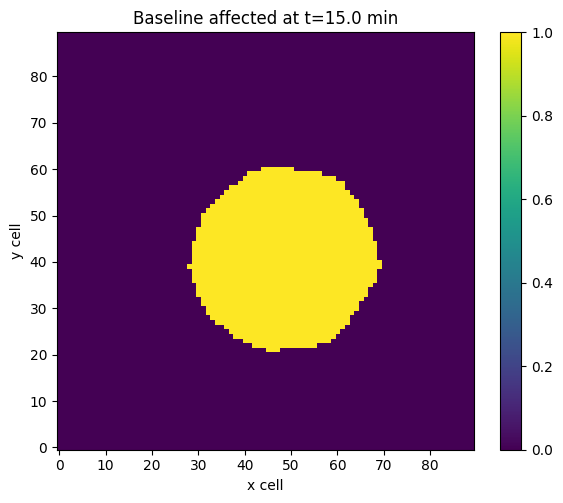

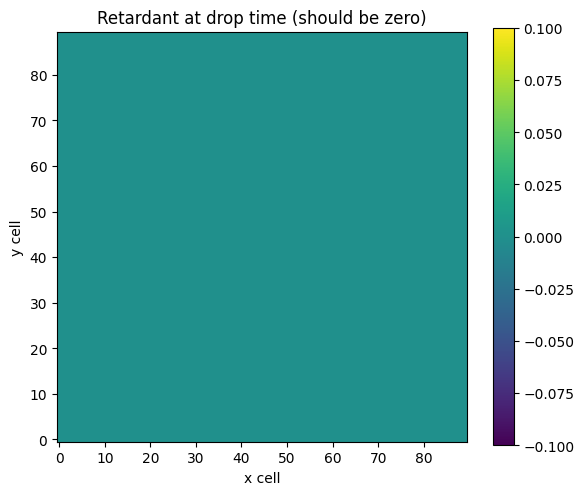

In [4]:
ignition_center = (nx // 2, ny // 2 - 6)
ignition_radius_km = 0.2

drop_time_s = 15 * 60      # when a drop would occur (seconds after ignition)
eval_horizon_s = 45 * 60   # evaluation horizon after drop_time_s

# State at drop time (no retardant)
init_state = finsler.simulate_from_ignition(
    T=drop_time_s,
    center=ignition_center,
    radius_km=ignition_radius_km,
    drone_params=None,
    start_time_s=0.0,
)

plot_firestate(init_state, kind="affected", title=f"Baseline affected at t={drop_time_s/60:.1f} min")
plot_firestate(init_state, kind="retardant", title="Retardant at drop time (should be zero)")


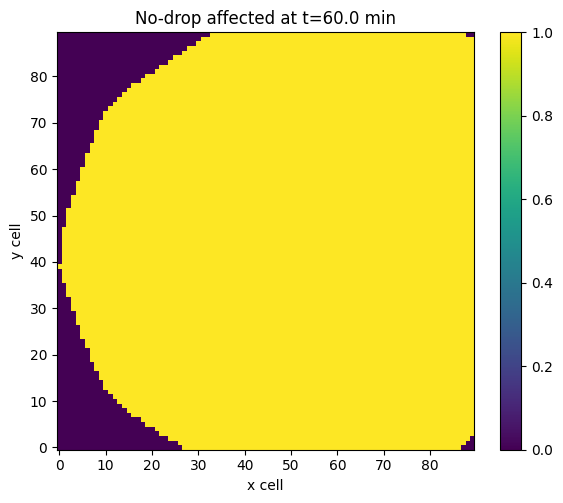

In [5]:
state_no_drop = finsler.simulate_from_firestate(
    init_state,
    T=eval_horizon_s,
    drone_params=None,
)

plot_firestate(state_no_drop, kind="affected", title=f"No-drop affected at t={(drop_time_s+eval_horizon_s)/60:.1f} min")


## 4. Retardant drop + half-life decay

We apply a single rectangular drop and inspect:
- fire evolution impact
- retardant field decay over time


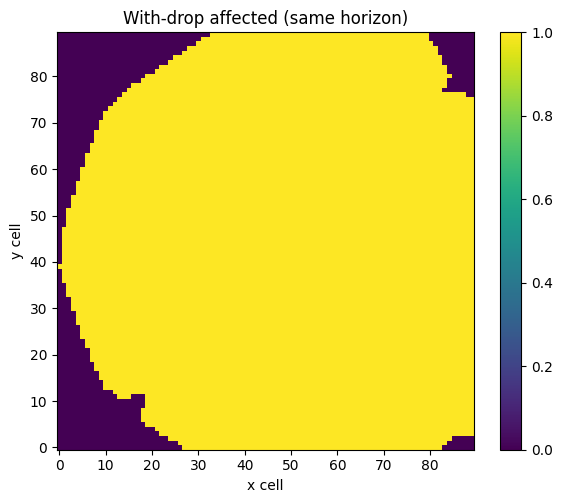

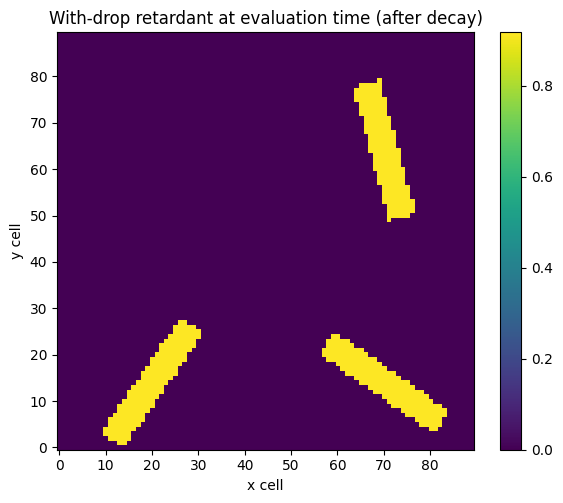

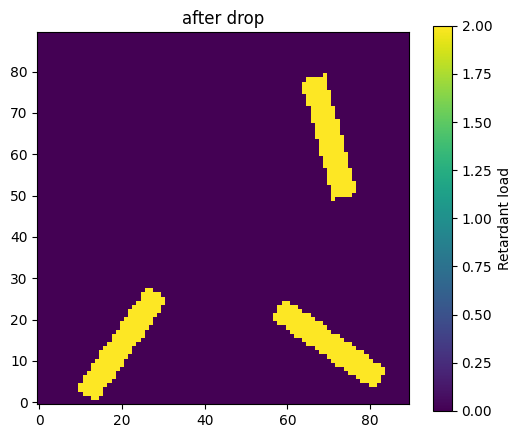

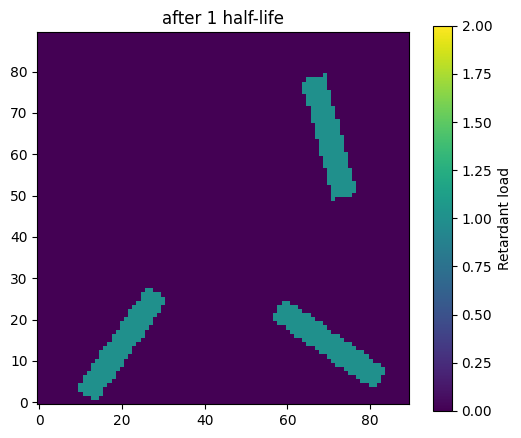

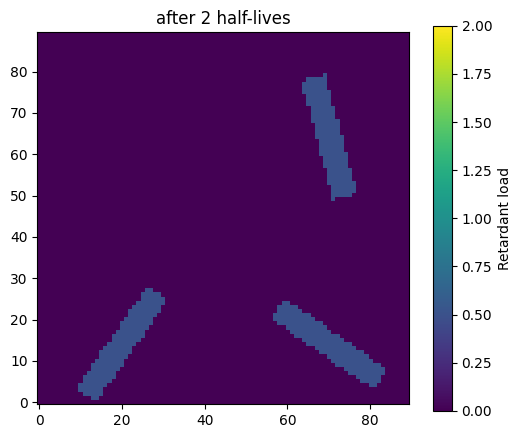

In [6]:
# Three drone parameters: (x0, y0, phi)
# Roughly bracket the active front with different headings
demo_drone_params = np.array([
    (ignition_center[0] + 25, ignition_center[1] + 25, np.deg2rad(15)),
    (ignition_center[0] - 25, ignition_center[1] - 25, np.deg2rad(-35)),
    (ignition_center[0] + 25, ignition_center[1] - 25, np.deg2rad(55)),
], dtype=float)

state_with_drop = finsler.simulate_from_firestate(
    init_state,
    T=eval_horizon_s,
    drone_params=demo_drone_params,
)

plot_firestate(state_with_drop, kind="affected", title="With-drop affected (same horizon)")
plot_firestate(state_with_drop, kind="retardant", title="With-drop retardant at evaluation time (after decay)")

# Visualise decay explicitly by querying the firestate at multiple absolute times.
t_abs0 = drop_time_s
t_abs1 = drop_time_s + retardant_half_life_s
t_abs2 = drop_time_s + 2 * retardant_half_life_s

# Re-run from ignition to ensure we view the drop starting at drop time
_ = finsler.simulate_from_ignition(T=drop_time_s, center=ignition_center, radius_km=ignition_radius_km)
# apply drop starting at t=drop_time_s
finsler.reset_retardant()
finsler._start_time_s = drop_time_s
finsler._retardant_t0_s = drop_time_s
finsler.apply_retardant_cartesian(demo_drone_params)
finsler.init_state(center=ignition_center, radius_km=ignition_radius_km)

st0 = finsler.firestate_at_time(t_abs0)
st1 = finsler.firestate_at_time(t_abs1)
st2 = finsler.firestate_at_time(t_abs2)

vmax = st0.retardant.max()
for state, title in [(st0, "after drop"), (st1, "after 1 half-life"), (st2, "after 2 half-lives")]:
    r = state.retardant[0]
    plt.figure(figsize=(6,5))
    plt.imshow(r.T, origin="lower", aspect="equal", vmin=0.0, vmax=vmax)
    plt.colorbar(label="Retardant load")
    plt.title(title)
    plt.show()



## 5. Fire boundary extraction in deterministic Finsler

In deterministic Finsler, the boundary is an **isochrone** (front) at a given time. `p_boundary` is just a threshold used by the boundary-extraction utility; for binary fields it can be fixed to `0.5`.

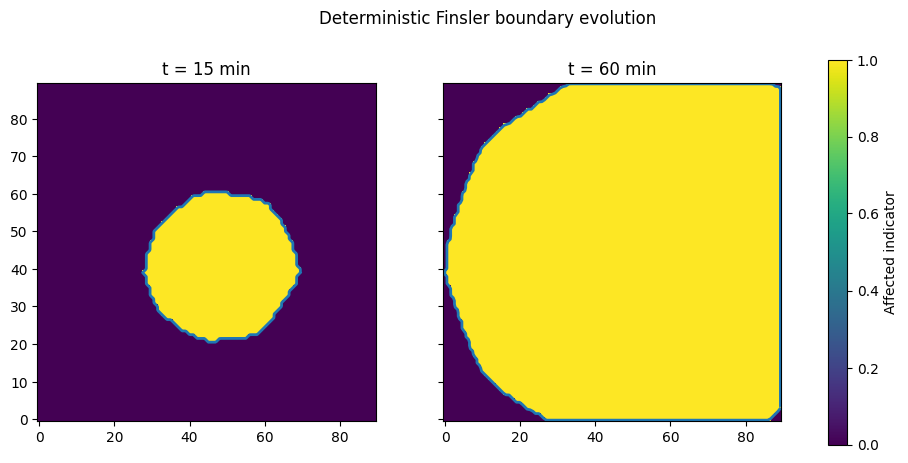

In [7]:
boundary_K = 360
p_boundary = 0.5  # threshold (not a probability in the deterministic model)

b_init = finsler.extract_fire_boundary(init_state, K=boundary_K, p_boundary=p_boundary, field="affected")
b_final = finsler.extract_fire_boundary(state_no_drop, K=boundary_K, p_boundary=p_boundary, field="affected")

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)
for ax, st, bd, label in [
    (axes[0], init_state, b_init, f"t = {drop_time_s/60:.0f} min"),
    (axes[1], state_no_drop, b_final, f"t = {(drop_time_s+eval_horizon_s)/60:.0f} min"),
]:
    field = ((st.burning[0] > 0.5) | (st.burned[0] > 0.5)).astype(float)
    im = ax.imshow(field.T, origin="lower", aspect="equal")
    ax.plot(bd.xy[:, 0], bd.xy[:, 1], linewidth=2)
    ax.set_title(label)
plt.colorbar(im, ax=axes.ravel().tolist(), label="Affected indicator")
plt.suptitle("Deterministic Finsler boundary evolution")
plt.show()


## 6. Search domain (between boundaries)

We optimise only over a band between the boundary at drop time and at the evaluation horizon.

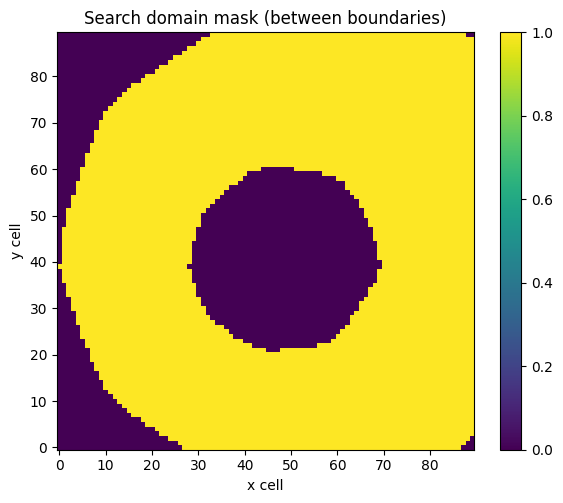

Valid search cells: 5976


In [8]:
search_mask = finsler.generate_search_domain(
    T=eval_horizon_s,
    init_firestate=init_state,
    p_boundary=0.5,
    K=300,
    boundary_field="affected",
)

plot_field(search_mask.astype(float), title="Search domain mask (between boundaries)")
xs_idx, ys_idx = np.where(search_mask)
coords = np.stack([xs_idx.astype(float), ys_idx.astype(float)], axis=1)
print("Valid search cells:", coords.shape[0])


## 7. Bayesian Optimisation (deterministic)

We minimise a deterministic objective:
- simulate Finsler to evaluation horizon with a candidate drop
- compute value-weighted burned area

Because the model is deterministic, the objective is deterministic (no Monte Carlo averaging).

In [9]:
from fire_model.bo import RetardantDropBayesOpt

drop_opt = RetardantDropBayesOpt(
    fire_model=finsler,
    init_firestate=init_state,
    n_drones=3,
    evolution_time_s=eval_horizon_s,
    n_sims=1,
    fire_boundary_probability=0.5,
)
search_mask, coords = drop_opt.setup_search_grid(K=300, boundary_field="affected")
best_theta, best_params, best_value, (X, y), y_nexts, y_bests = drop_opt.run_bayes_opt(
    n_init=50,
    n_iters=150,
    n_candidates=3000,
    xi=0.01,
    verbose=True,
)

[BO] init: n_init=50, dim=9, n_cells=5976
[BO] init: best_y=10.0072, mean_y=10.4488, std_y=0.109586
[BO] iter 001/150 | y_next=9.71535 | best_y=9.71535 (improved) | EI_max=1.47e-05 | mu=10.3437 | std=0.106
      proposed (x,y,phi) per drone:
      [[ 0.         39.          1.69434211]
 [22.          3.          4.44764803]
 [26.         46.          0.67641931]]
      gp.kernel_ = 1**2 * TiedXYFiMatern(lx=0.321, ly=0.202, lphi=0.734, nu=2.5) + WhiteKernel(noise_level=1.81e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lphi is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 002/150 | y_next=10.4321 | best_y=9.71535 (no-improve) | EI_max=1.93e-06 | mu=10.2161 | std=0.133
      proposed (x,y,phi) per drone:
      [[ 0.         39.          1.27075658]
 [12.         65.         -0.40425994]
 [27.          0.          5.29481908]]
      gp.kernel_ = 0.941**2 * TiedXYFiMatern(lx=1e+03, ly=0.196, lphi=0.858, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lphi is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 003/150 | y_next=10.5864 | best_y=9.71535 (no-improve) | EI_max=1.38e-06 | mu=10.2224 | std=0.132
      proposed (x,y,phi) per drone:
      [[ 2.         51.          2.54151316]
 [16.          7.          6.07139254]
 [57.         59.         -0.22802626]]
      gp.kernel_ = 0.952**2 * TiedXYFiMatern(lx=1e+03, ly=0.158, lphi=0.771, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 004/150 | y_next=10.493 | best_y=9.71535 (no-improve) | EI_max=6.86e-07 | mu=10.2585 | std=0.136
      proposed (x,y,phi) per drone:
      [[ 0.         39.          1.1295614 ]
 [14.         41.          3.67816682]
 [16.          7.          5.50661184]]
      gp.kernel_ = 0.969**2 * TiedXYFiMatern(lx=0.347, ly=0.156, lphi=0.835, nu=2.5) + WhiteKernel(noise_level=1e-06)
[BO] iter 005/150 | y_next=10.2794 | best_y=9.71535 (no-improve) | EI_max=4.25e-08 | mu=10.3752 | std=0.143
      proposed (x,y,phi) per drone:
      [[ 0.         39.          1.90613487]
 [ 6.         60.          4.6495244 ]
 [16.          7.          1.90613487]]
      gp.kernel_ = 0.985**2 * TiedXYFiMatern(lx=0.307, ly=0.137, lphi=0.596, nu=2.5) + WhiteKernel(noise_level=8.49e-06)
[BO] iter 006/150 | y_next=10.3757 | best_y=9.71535 (no-improve) | EI_max=1.83e-07 | mu=10.3241 | std=0.142
      proposed (x,y,phi) per drone:
      [[ 2.         33.          1.97673246]
 [ 3.         42.          3.07157351

/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 013/150 | y_next=10.499 | best_y=9.71535 (no-improve) | EI_max=1.09e-05 | mu=10.1379 | std=0.127
      proposed (x,y,phi) per drone:
      [[ 0.         39.          2.25912281]
 [28.         40.         -3.87261162]
 [86.          0.          4.73003838]]
      gp.kernel_ = 0.981**2 * TiedXYFiMatern(lx=0.0623, ly=0.195, lphi=1e+03, nu=2.5) + WhiteKernel(noise_level=1.72e-06)
[BO] iter 014/150 | y_next=10.3513 | best_y=9.71535 (no-improve) | EI_max=6.3e-08 | mu=10.3247 | std=0.135
      proposed (x,y,phi) per drone:
      [[ 0.         39.          2.68270833]
 [23.         39.         -3.39367573]
 [27.          0.          2.32972039]]
      gp.kernel_ = 0.835**2 * TiedXYFiMatern(lx=0.191, ly=0.145, lphi=0.973, nu=2.5) + WhiteKernel(noise_level=0.274)
[BO] iter 015/150 | y_next=10.4099 | best_y=9.71535 (no-improve) | EI_max=2.34e-08 | mu=10.3544 | std=0.136
      proposed (x,y,phi) per drone:
      [[ 0.         39.          2.04733004]
 [ 5.         24.          3.17689145

/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 017/150 | y_next=10.5356 | best_y=9.71535 (no-improve) | EI_max=1.5e-05 | mu=10.0995 | std=0.119
      proposed (x,y,phi) per drone:
      [[ 0.         39.          5.85959978]
 [27.          0.          4.51824561]
 [27.         85.          4.90898805]]
      gp.kernel_ = 0.989**2 * TiedXYFiMatern(lx=0.0995, ly=384, lphi=0.813, nu=2.5) + WhiteKernel(noise_level=1e-06)
[BO] iter 018/150 | y_next=10.4439 | best_y=9.71535 (no-improve) | EI_max=1.12e-07 | mu=10.2908 | std=0.131
      proposed (x,y,phi) per drone:
      [[ 0.         39.          1.76493969]
 [28.         38.          2.73063032]
 [30.          0.          4.73003838]]
      gp.kernel_ = 0.877**2 * TiedXYFiMatern(lx=0.116, ly=0.241, lphi=0.932, nu=2.5) + WhiteKernel(noise_level=0.204)
[BO] iter 019/150 | y_next=9.74547 | best_y=9.71535 (no-improve) | EI_max=6.05e-08 | mu=10.3087 | std=0.132
      proposed (x,y,phi) per drone:
      [[ 0.         39.          1.69434211]
 [16.          7.          4.65944079]
 [

/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 020/150 | y_next=10.3003 | best_y=9.71535 (no-improve) | EI_max=1.98e-05 | mu=10.1025 | std=0.123
      proposed (x,y,phi) per drone:
      [[13.         44.         -1.84293427]
 [30.         84.          4.37705044]
 [85.         35.          1.83553728]]
      gp.kernel_ = 0.894**2 * TiedXYFiMatern(lx=0.192, ly=0.075, lphi=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 021/150 | y_next=9.95536 | best_y=9.71535 (no-improve) | EI_max=1.64e-05 | mu=10.1372 | std=0.131
      proposed (x,y,phi) per drone:
      [[ 0.         39.          2.11792763]
 [10.         13.          3.60047697]
 [30.         48.          5.07192793]]
      gp.kernel_ = 0.893**2 * TiedXYFiMatern(lx=0.151, ly=0.0765, lphi=4.93, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 022/150 | y_next=10.307 | best_y=9.71535 (no-improve) | EI_max=6.06e-05 | mu=10.0234 | std=0.11
      proposed (x,y,phi) per drone:
      [[12.         11.          4.0240625 ]
 [33.         53.         -3.38122171]
 [75.         34.          1.83553728]]
      gp.kernel_ = 0.863**2 * TiedXYFiMatern(lx=0.158, ly=0.0818, lphi=940, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 023/150 | y_next=10.4498 | best_y=9.71535 (no-improve) | EI_max=6.63e-07 | mu=10.2218 | std=0.127
      proposed (x,y,phi) per drone:
      [[ 0.         39.          1.55314693]
 [19.         44.         -4.77137763]
 [44.         77.          4.0240625 ]]
      gp.kernel_ = 0.875**2 * TiedXYFiMatern(lx=0.212, ly=0.0759, lphi=2.68, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 024/150 | y_next=10.2478 | best_y=9.71535 (no-improve) | EI_max=2.43e-06 | mu=10.2292 | std=0.138
      proposed (x,y,phi) per drone:
      [[ 0.         39.          2.18852522]
 [10.         43.          3.39644159]
 [16.          7.          3.74167215]]
      gp.kernel_ = 0.887**2 * TiedXYFiMatern(lx=0.192, ly=0.0794, lphi=2.14, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 025/150 | y_next=10.3267 | best_y=9.71535 (no-improve) | EI_max=5.41e-06 | mu=10.1465 | std=0.123
      proposed (x,y,phi) per drone:
      [[ 0.         39.          1.48254934]
 [30.         48.          0.08838307]
 [86.          0.          4.0240625 ]]
      gp.kernel_ = 0.883**2 * TiedXYFiMatern(lx=0.189, ly=0.0789, lphi=2.15, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 026/150 | y_next=10.5678 | best_y=9.71535 (no-improve) | EI_max=6.08e-07 | mu=10.2783 | std=0.139
      proposed (x,y,phi) per drone:
      [[ 0.         39.          1.83553728]
 [29.         46.         -3.52042879]
 [86.          0.          5.50661184]]
      gp.kernel_ = 0.891**2 * TiedXYFiMatern(lx=0.171, ly=0.0814, lphi=1.92, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 027/150 | y_next=9.9344 | best_y=9.71535 (no-improve) | EI_max=5.84e-05 | mu=10.077 | std=0.126
      proposed (x,y,phi) per drone:
      [[ 0.         39.          1.83553728]
 [16.          7.          4.0240625 ]
 [25.         41.         -5.27666623]]
      gp.kernel_ = 0.901**2 * TiedXYFiMatern(lx=0.168, ly=0.0903, lphi=1.57, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 028/150 | y_next=10.4963 | best_y=9.71535 (no-improve) | EI_max=1.84e-06 | mu=10.2376 | std=0.138
      proposed (x,y,phi) per drone:
      [[ 0.         39.          1.83553728]
 [ 0.         39.          3.67107456]
 [13.         46.         -4.41928966]]
      gp.kernel_ = 0.871**2 * TiedXYFiMatern(lx=0.163, ly=0.0965, lphi=1.68, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 029/150 | y_next=10.4593 | best_y=9.71535 (no-improve) | EI_max=2.32e-06 | mu=10.2175 | std=0.135
      proposed (x,y,phi) per drone:
      [[ 0.         39.          1.90613487]
 [ 2.         33.          3.31808662]
 [18.         48.         -2.9048007 ]]
      gp.kernel_ = 0.882**2 * TiedXYFiMatern(lx=0.135, ly=0.0989, lphi=1.59, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 030/150 | y_next=10.3802 | best_y=9.71535 (no-improve) | EI_max=2.29e-06 | mu=10.2578 | std=0.145
      proposed (x,y,phi) per drone:
      [[ 0.         39.          1.55314693]
 [18.         43.         -5.03430918]
 [85.          0.          4.65944079]]
      gp.kernel_ = 0.891**2 * TiedXYFiMatern(lx=0.0991, ly=0.0905, lphi=2, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 031/150 | y_next=10.589 | best_y=9.71535 (no-improve) | EI_max=2.72e-07 | mu=10.2991 | std=0.139
      proposed (x,y,phi) per drone:
      [[ 0.         39.          1.83553728]
 [20.         49.         -5.65820356]
 [73.          0.          4.09466009]]
      gp.kernel_ = 0.894**2 * TiedXYFiMatern(lx=0.0967, ly=0.0922, lphi=1.85, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 032/150 | y_next=10.4167 | best_y=9.71535 (no-improve) | EI_max=5.04e-05 | mu=10.1336 | std=0.142
      proposed (x,y,phi) per drone:
      [[ 0.         39.          1.55314693]
 [ 7.         19.          4.73003838]
 [25.         40.          5.97971048]]
      gp.kernel_ = 0.906**2 * TiedXYFiMatern(lx=0.119, ly=0.0955, lphi=1.42, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 033/150 | y_next=10.5928 | best_y=9.71535 (no-improve) | EI_max=7.14e-07 | mu=10.306 | std=0.147
      proposed (x,y,phi) per drone:
      [[ 0.         39.          1.41195175]
 [27.          0.          3.60047697]
 [29.         46.         -2.2437395 ]]
      gp.kernel_ = 0.919**2 * TiedXYFiMatern(lx=0.136, ly=0.084, lphi=1.16, nu=2.5) + WhiteKernel(noise_level=1e-06)
[BO] iter 034/150 | y_next=10.4301 | best_y=9.71535 (no-improve) | EI_max=8.93e-07 | mu=10.3309 | std=0.155
      proposed (x,y,phi) per drone:
      [[ 0.         39.          2.47091557]
 [10.         13.          4.30645285]
 [26.         42.          5.84568782]]
      gp.kernel_ = 0.927**2 * TiedXYFiMatern(lx=0.0954, ly=0.0758, lphi=1.38, nu=2.5) + WhiteKernel(noise_level=1.05e-06)
[BO] iter 035/150 | y_next=10.0876 | best_y=9.71535 (no-improve) | EI_max=5.09e-07 | mu=10.3316 | std=0.15
      proposed (x,y,phi) per drone:
      [[ 0.         39.          1.83553728]
 [11.         12.          4.0240625 ]

/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 036/150 | y_next=10.3055 | best_y=9.71535 (no-improve) | EI_max=1.4e-06 | mu=10.2996 | std=0.151
      proposed (x,y,phi) per drone:
      [[26.         36.         -3.05317948]
 [78.         35.          1.83553728]
 [88.         15.          4.0240625 ]]
      gp.kernel_ = 0.926**2 * TiedXYFiMatern(lx=0.0781, ly=0.065, lphi=2.23, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 037/150 | y_next=10.3993 | best_y=9.71535 (no-improve) | EI_max=8e-07 | mu=10.3099 | std=0.149
      proposed (x,y,phi) per drone:
      [[ 0.         39.          1.83553728]
 [16.         78.          4.65944079]
 [29.         45.          3.92297251]]
      gp.kernel_ = 0.925**2 * TiedXYFiMatern(lx=0.0772, ly=0.0645, lphi=2.33, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 038/150 | y_next=10.5595 | best_y=9.71535 (no-improve) | EI_max=1.89e-06 | mu=10.2877 | std=0.15
      proposed (x,y,phi) per drone:
      [[ 0.         39.          2.25912281]
 [10.         72.          3.38868421]
 [29.         47.         -4.96463567]]
      gp.kernel_ = 0.926**2 * TiedXYFiMatern(lx=0.0804, ly=0.0659, lphi=1.96, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 039/150 | y_next=10.449 | best_y=9.71535 (no-improve) | EI_max=7.2e-07 | mu=10.3242 | std=0.151
      proposed (x,y,phi) per drone:
      [[ 2.         33.          1.27075658]
 [ 7.         19.          4.0240625 ]
 [22.         40.         -6.28139877]]
      gp.kernel_ = 0.931**2 * TiedXYFiMatern(lx=0.091, ly=0.071, lphi=1.36, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 040/150 | y_next=10.4294 | best_y=9.71535 (no-improve) | EI_max=2.35e-06 | mu=10.241 | std=0.141
      proposed (x,y,phi) per drone:
      [[ 0.         39.          2.25912281]
 [ 1.         36.          3.60047697]
 [25.         51.          0.89278041]]
      gp.kernel_ = 0.934**2 * TiedXYFiMatern(lx=0.0941, ly=0.0679, lphi=1.36, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 041/150 | y_next=10.4165 | best_y=9.71535 (no-improve) | EI_max=3.35e-07 | mu=10.3645 | std=0.155
      proposed (x,y,phi) per drone:
      [[ 0.         39.          1.55314693]
 [14.         46.         -2.10010791]
 [15.          8.          4.37705044]]
      gp.kernel_ = 0.941**2 * TiedXYFiMatern(lx=0.091, ly=0.0652, lphi=1.29, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 042/150 | y_next=10.216 | best_y=9.71535 (no-improve) | EI_max=2.45e-07 | mu=10.3631 | std=0.152
      proposed (x,y,phi) per drone:
      [[10.         72.          3.52987939]
 [28.         41.          3.03211   ]
 [78.         31.          2.11792763]]
      gp.kernel_ = 0.942**2 * TiedXYFiMatern(lx=0.0861, ly=0.0647, lphi=1.34, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 043/150 | y_next=10.349 | best_y=9.71535 (no-improve) | EI_max=2.84e-06 | mu=10.2825 | std=0.153
      proposed (x,y,phi) per drone:
      [[ 0.         39.          2.25912281]
 [27.          0.          3.60047697]
 [28.         40.          3.58284635]]
      gp.kernel_ = 0.941**2 * TiedXYFiMatern(lx=0.0821, ly=0.0607, lphi=1.56, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 044/150 | y_next=10.3767 | best_y=9.71535 (no-improve) | EI_max=2.93e-06 | mu=10.2514 | std=0.145
      proposed (x,y,phi) per drone:
      [[ 7.         19.          4.0240625 ]
 [22.         35.          1.83553728]
 [28.         38.         -6.08637328]]
      gp.kernel_ = 0.942**2 * TiedXYFiMatern(lx=0.0823, ly=0.0606, lphi=1.48, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 045/150 | y_next=10.2666 | best_y=9.71535 (no-improve) | EI_max=4.71e-07 | mu=10.332 | std=0.15
      proposed (x,y,phi) per drone:
      [[ 7.         19.          3.60047697]
 [22.         35.          1.83553728]
 [29.         35.         -6.09248338]]
      gp.kernel_ = 0.944**2 * TiedXYFiMatern(lx=0.0849, ly=0.061, lphi=1.34, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 046/150 | y_next=10.3021 | best_y=9.71535 (no-improve) | EI_max=5.28e-07 | mu=10.3168 | std=0.147
      proposed (x,y,phi) per drone:
      [[ 0.         39.          1.34135417]
 [26.         44.          4.16233754]
 [83.          0.          4.23585526]]
      gp.kernel_ = 0.943**2 * TiedXYFiMatern(lx=0.086, ly=0.0624, lphi=1.32, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 047/150 | y_next=10.1938 | best_y=9.71535 (no-improve) | EI_max=1.95e-07 | mu=10.377 | std=0.153
      proposed (x,y,phi) per drone:
      [[ 0.         39.          2.25912281]
 [16.          7.          2.25912281]
 [29.         33.         -2.46712821]]
      gp.kernel_ = 0.942**2 * TiedXYFiMatern(lx=0.085, ly=0.062, lphi=1.35, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 048/150 | y_next=10.5451 | best_y=9.71535 (no-improve) | EI_max=4.56e-07 | mu=10.3441 | std=0.152
      proposed (x,y,phi) per drone:
      [[ 9.         15.          3.24748904]
 [24.         42.          5.80115004]
 [33.         27.          2.68270833]]
      gp.kernel_ = 0.943**2 * TiedXYFiMatern(lx=0.0876, ly=0.0684, lphi=1.24, nu=2.5) + WhiteKernel(noise_level=1e-06)
[BO] iter 049/150 | y_next=10.3713 | best_y=9.71535 (no-improve) | EI_max=2.87e-07 | mu=10.3553 | std=0.151
      proposed (x,y,phi) per drone:
      [[ 1.         47.          4.51824561]
 [ 2.         51.          4.37705044]
 [35.         26.         -2.69373922]]
      gp.kernel_ = 0.945**2 * TiedXYFiMatern(lx=0.0817, ly=0.0622, lphi=1.34, nu=2.5) + WhiteKernel(noise_level=1.35e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 050/150 | y_next=10.2937 | best_y=9.71535 (no-improve) | EI_max=7.85e-07 | mu=10.3213 | std=0.151
      proposed (x,y,phi) per drone:
      [[ 0.         39.          1.83553728]
 [ 0.         39.          4.80063597]
 [29.         45.         -2.00478985]]
      gp.kernel_ = 0.945**2 * TiedXYFiMatern(lx=0.0816, ly=0.0621, lphi=1.34, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 051/150 | y_next=10.6036 | best_y=9.71535 (no-improve) | EI_max=4.35e-07 | mu=10.3388 | std=0.151
      proposed (x,y,phi) per drone:
      [[10.         34.          1.48254934]
 [27.          0.          4.73003838]
 [30.         48.          6.24306236]]
      gp.kernel_ = 0.944**2 * TiedXYFiMatern(lx=0.0818, ly=0.062, lphi=1.34, nu=2.5) + WhiteKernel(noise_level=1e-06)
[BO] iter 052/150 | y_next=10.1227 | best_y=9.71535 (no-improve) | EI_max=3.4e-07 | mu=10.3533 | std=0.152
      proposed (x,y,phi) per drone:
      [[ 0.         39.          2.25912281]
 [28.         40.          1.02462074]
 [68.         58.          4.44764803]]
      gp.kernel_ = 0.949**2 * TiedXYFiMatern(lx=0.0831, ly=0.056, lphi=1.39, nu=2.5) + WhiteKernel(noise_level=1.16e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 053/150 | y_next=10.5668 | best_y=9.71535 (no-improve) | EI_max=1.6e-05 | mu=10.1994 | std=0.148
      proposed (x,y,phi) per drone:
      [[27.          0.          3.81226974]
 [29.         45.          4.5366914 ]
 [65.         31.          1.97673246]]
      gp.kernel_ = 0.949**2 * TiedXYFiMatern(lx=0.0791, ly=0.0547, lphi=1.59, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 054/150 | y_next=10.1673 | best_y=9.71535 (no-improve) | EI_max=1.27e-06 | mu=10.3209 | std=0.155
      proposed (x,y,phi) per drone:
      [[ 0.         39.          1.83553728]
 [22.          3.          4.30645285]
 [29.         35.         -4.44546707]]
      gp.kernel_ = 0.956**2 * TiedXYFiMatern(lx=0.0902, ly=0.0967, lphi=0.873, nu=2.5) + WhiteKernel(noise_level=1e-06)
[BO] iter 055/150 | y_next=10.5212 | best_y=9.71535 (no-improve) | EI_max=2.35e-06 | mu=10.277 | std=0.15
      proposed (x,y,phi) per drone:
      [[ 0.         39.          2.96509868]
 [12.         11.          3.52987939]
 [28.         38.         -5.54933643]]
      gp.kernel_ = 0.952**2 * TiedXYFiMatern(lx=0.0907, ly=0.19, lphi=0.766, nu=2.5) + WhiteKernel(noise_level=1.04e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 056/150 | y_next=10.5342 | best_y=9.71535 (no-improve) | EI_max=1e-06 | mu=10.3022 | std=0.149
      proposed (x,y,phi) per drone:
      [[ 0.         39.          2.82390351]
 [10.         13.          2.54151316]
 [26.         51.         -4.28170074]]
      gp.kernel_ = 0.955**2 * TiedXYFiMatern(lx=0.0787, ly=0.124, lphi=0.852, nu=2.5) + WhiteKernel(noise_level=1e-06)
[BO] iter 057/150 | y_next=10.5003 | best_y=9.71535 (no-improve) | EI_max=1.27e-06 | mu=10.3059 | std=0.152
      proposed (x,y,phi) per drone:
      [[ 0.         39.          4.44764803]
 [29.         32.          1.69434211]
 [29.         45.         -5.95133123]]
      gp.kernel_ = 0.959**2 * TiedXYFiMatern(lx=0.0853, ly=0.0799, lphi=0.931, nu=2.5) + WhiteKernel(noise_level=2.75e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 058/150 | y_next=10.3693 | best_y=9.71535 (no-improve) | EI_max=2.73e-06 | mu=10.2898 | std=0.154
      proposed (x,y,phi) per drone:
      [[ 0.         39.          2.47091557]
 [27.          0.          4.5888432 ]
 [28.         38.         -4.75971161]]
      gp.kernel_ = 0.963**2 * TiedXYFiMatern(lx=0.0915, ly=0.111, lphi=0.789, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 059/150 | y_next=9.7142 | best_y=9.7142 (improved) | EI_max=5.1e-06 | mu=10.2628 | std=0.153
      proposed (x,y,phi) per drone:
      [[ 0.         39.          1.83553728]
 [10.         13.          4.51824561]
 [30.         48.          4.24342641]]
      gp.kernel_ = 0.963**2 * TiedXYFiMatern(lx=0.0919, ly=0.0951, lphi=0.813, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 060/150 | y_next=10.4342 | best_y=9.7142 (no-improve) | EI_max=4.46e-06 | mu=10.2937 | std=0.16
      proposed (x,y,phi) per drone:
      [[ 0.         39.          1.62374452]
 [10.         13.          4.23585526]
 [22.         41.          5.39767233]]
      gp.kernel_ = 0.947**2 * TiedXYFiMatern(lx=0.0887, ly=0.0826, lphi=0.995, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 061/150 | y_next=10.3479 | best_y=9.7142 (no-improve) | EI_max=1.63e-06 | mu=10.3484 | std=0.164
      proposed (x,y,phi) per drone:
      [[ 0.         39.          1.55314693]
 [33.         56.          3.58869794]
 [84.          0.          4.23585526]]
      gp.kernel_ = 0.95**2 * TiedXYFiMatern(lx=0.0833, ly=0.0794, lphi=1.02, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 062/150 | y_next=10.282 | best_y=9.7142 (no-improve) | EI_max=1.6e-06 | mu=10.3289 | std=0.159
      proposed (x,y,phi) per drone:
      [[ 0.         39.          2.11792763]
 [24.         39.         -0.96800443]
 [48.          0.          3.74167215]]
      gp.kernel_ = 0.95**2 * TiedXYFiMatern(lx=0.0832, ly=0.0794, lphi=1.02, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 063/150 | y_next=10.3446 | best_y=9.7142 (no-improve) | EI_max=1.19e-06 | mu=10.342 | std=0.16
      proposed (x,y,phi) per drone:
      [[ 0.         39.          4.23585526]
 [38.         23.         -2.80128386]
 [86.          0.          4.0240625 ]]
      gp.kernel_ = 0.949**2 * TiedXYFiMatern(lx=0.0841, ly=0.0782, lphi=1.03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 064/150 | y_next=10.5644 | best_y=9.7142 (no-improve) | EI_max=8.31e-07 | mu=10.3692 | std=0.163
      proposed (x,y,phi) per drone:
      [[ 0.         39.          1.55314693]
 [ 6.         63.          2.82390351]
 [30.         48.          5.92640708]]
      gp.kernel_ = 0.949**2 * TiedXYFiMatern(lx=0.0847, ly=0.0781, lphi=1.03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 065/150 | y_next=10.1055 | best_y=9.7142 (no-improve) | EI_max=1.7e-06 | mu=10.3337 | std=0.161
      proposed (x,y,phi) per drone:
      [[ 0.         39.          2.47091557]
 [26.         45.         -1.01881111]
 [27.          0.          4.44764803]]
      gp.kernel_ = 0.95**2 * TiedXYFiMatern(lx=0.0823, ly=0.0774, lphi=1.03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 066/150 | y_next=10.3895 | best_y=9.7142 (no-improve) | EI_max=3.59e-06 | mu=10.3032 | std=0.16
      proposed (x,y,phi) per drone:
      [[ 0.         39.          1.83553728]
 [30.         48.          5.18215197]
 [88.          2.          4.30645285]]
      gp.kernel_ = 0.949**2 * TiedXYFiMatern(lx=0.0789, ly=0.0907, lphi=1.01, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 067/150 | y_next=10.4601 | best_y=9.7142 (no-improve) | EI_max=9.77e-07 | mu=10.3604 | std=0.162
      proposed (x,y,phi) per drone:
      [[ 1.         47.          3.88286732]
 [32.         19.         -1.55890465]
 [76.         47.          4.65944079]]
      gp.kernel_ = 0.95**2 * TiedXYFiMatern(lx=0.0805, ly=0.0917, lphi=0.986, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 068/150 | y_next=9.94219 | best_y=9.7142 (no-improve) | EI_max=3.79e-05 | mu=10.1755 | std=0.151
      proposed (x,y,phi) per drone:
      [[ 0.         39.          1.76493969]
 [12.         11.          4.0240625 ]
 [24.         44.          3.32680534]]
      gp.kernel_ = 0.95**2 * TiedXYFiMatern(lx=0.0792, ly=0.0908, lphi=0.989, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 069/150 | y_next=10.1342 | best_y=9.7142 (no-improve) | EI_max=3.68e-06 | mu=10.3093 | std=0.162
      proposed (x,y,phi) per drone:
      [[ 3.         30.          2.18852522]
 [20.         38.         -6.21642698]
 [27.          0.          2.75330592]]
      gp.kernel_ = 0.937**2 * TiedXYFiMatern(lx=0.102, ly=0.0835, lphi=0.979, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 070/150 | y_next=10.4402 | best_y=9.7142 (no-improve) | EI_max=6.83e-05 | mu=10.1283 | std=0.144
      proposed (x,y,phi) per drone:
      [[ 0.         39.          1.55314693]
 [ 7.         19.          4.80063597]
 [29.         46.         -2.38773271]]
      gp.kernel_ = 0.936**2 * TiedXYFiMatern(lx=0.108, ly=0.0863, lphi=0.975, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 071/150 | y_next=10.4354 | best_y=9.7142 (no-improve) | EI_max=1.66e-06 | mu=10.362 | std=0.168
      proposed (x,y,phi) per drone:
      [[ 0.         39.          1.34135417]
 [ 8.         17.          6.00079496]
 [29.         45.          5.80411841]]
      gp.kernel_ = 0.948**2 * TiedXYFiMatern(lx=0.126, ly=0.0701, lphi=0.927, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 072/150 | y_next=10.2403 | best_y=9.7142 (no-improve) | EI_max=1.63e-06 | mu=10.3594 | std=0.167
      proposed (x,y,phi) per drone:
      [[ 0.         39.          1.83553728]
 [27.          0.          4.80063597]
 [29.         45.          1.530453  ]]
      gp.kernel_ = 0.948**2 * TiedXYFiMatern(lx=0.122, ly=0.0692, lphi=0.935, nu=2.5) + WhiteKernel(noise_level=1e-06)
[BO] iter 073/150 | y_next=10.0451 | best_y=9.7142 (no-improve) | EI_max=1.59e-06 | mu=10.3539 | std=0.165
      proposed (x,y,phi) per drone:
      [[ 0.         39.          1.62374452]
 [ 5.         24.          3.4592818 ]
 [26.         34.         -0.73305451]]
      gp.kernel_ = 0.949**2 * TiedXYFiMatern(lx=0.122, ly=0.073, lphi=0.918, nu=2.5) + WhiteKernel(noise_level=2.85e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 074/150 | y_next=10.3082 | best_y=9.7142 (no-improve) | EI_max=7.86e-06 | mu=10.292 | std=0.165
      proposed (x,y,phi) per drone:
      [[ 0.         39.          1.83553728]
 [15.         36.          2.07083105]
 [22.          3.          4.0240625 ]]
      gp.kernel_ = 0.95**2 * TiedXYFiMatern(lx=0.128, ly=0.0707, lphi=0.933, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 075/150 | y_next=10.3573 | best_y=9.7142 (no-improve) | EI_max=1.75e-06 | mu=10.3576 | std=0.167
      proposed (x,y,phi) per drone:
      [[21.         36.          6.050445  ]
 [24.         22.          2.47091557]
 [27.          0.          4.0240625 ]]
      gp.kernel_ = 0.95**2 * TiedXYFiMatern(lx=0.128, ly=0.0703, lphi=0.934, nu=2.5) + WhiteKernel(noise_level=1e-06)
[BO] iter 076/150 | y_next=10.0011 | best_y=9.7142 (no-improve) | EI_max=2.48e-05 | mu=10.1902 | std=0.15
      proposed (x,y,phi) per drone:
      [[ 0.         39.          1.83553728]
 [10.         13.          4.0240625 ]
 [29.         35.         -4.02635672]]
      gp.kernel_ = 0.95**2 * TiedXYFiMatern(lx=0.128, ly=0.0702, lphi=0.934, nu=2.5) + WhiteKernel(noise_level=1.82e-06)
[BO] iter 077/150 | y_next=10.4759 | best_y=9.7142 (no-improve) | EI_max=4.54e-06 | mu=10.3194 | std=0.167
      proposed (x,y,phi) per drone:
      [[ 0.         39.          1.55314693]
 [19.         43.         -5.40961467]
 

/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 078/150 | y_next=10.3867 | best_y=9.7142 (no-improve) | EI_max=3.3e-06 | mu=10.3342 | std=0.167
      proposed (x,y,phi) per drone:
      [[ 0.         39.          1.76493969]
 [20.         45.         -1.47147181]
 [67.          0.          2.68270833]]
      gp.kernel_ = 0.944**2 * TiedXYFiMatern(lx=0.131, ly=0.08, lphi=0.872, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 079/150 | y_next=10.2747 | best_y=9.7142 (no-improve) | EI_max=6.98e-06 | mu=10.2809 | std=0.161
      proposed (x,y,phi) per drone:
      [[ 0.         39.          2.25912281]
 [22.         33.          2.22381631]
 [27.          0.          4.09466009]]
      gp.kernel_ = 0.944**2 * TiedXYFiMatern(lx=0.13, ly=0.0791, lphi=0.875, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 080/150 | y_next=10.4173 | best_y=9.7142 (no-improve) | EI_max=3.11e-05 | mu=10.2115 | std=0.159
      proposed (x,y,phi) per drone:
      [[ 0.         39.          1.83553728]
 [16.          7.          4.30645285]
 [21.         46.          6.10741843]]
      gp.kernel_ = 0.943**2 * TiedXYFiMatern(lx=0.13, ly=0.0796, lphi=0.874, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 081/150 | y_next=9.78984 | best_y=9.7142 (no-improve) | EI_max=3.76e-06 | mu=10.3221 | std=0.166
      proposed (x,y,phi) per drone:
      [[ 0.         39.          2.11792763]
 [22.          3.          3.10629386]
 [30.         48.         -0.0661548 ]]
      gp.kernel_ = 0.946**2 * TiedXYFiMatern(lx=0.113, ly=0.0885, lphi=0.806, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 082/150 | y_next=10.2862 | best_y=9.7142 (no-improve) | EI_max=5.55e-05 | mu=10.1967 | std=0.162
      proposed (x,y,phi) per drone:
      [[ 0.         39.          1.76493969]
 [10.         13.          4.37705044]
 [30.         52.          5.44769527]]
      gp.kernel_ = 0.949**2 * TiedXYFiMatern(lx=0.129, ly=0.119, lphi=0.71, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 083/150 | y_next=10.4339 | best_y=9.7142 (no-improve) | EI_max=4.23e-06 | mu=10.3471 | std=0.173
      proposed (x,y,phi) per drone:
      [[ 0.         39.          1.83553728]
 [ 5.         24.          3.52987939]
 [17.         37.          3.28452958]]
      gp.kernel_ = 0.949**2 * TiedXYFiMatern(lx=0.132, ly=0.125, lphi=0.676, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 084/150 | y_next=10.1728 | best_y=9.7142 (no-improve) | EI_max=7.92e-06 | mu=10.316 | std=0.172
      proposed (x,y,phi) per drone:
      [[ 0.         39.          0.98836623]
 [ 7.         19.          2.47091557]
 [30.         48.          0.48603024]]
      gp.kernel_ = 0.949**2 * TiedXYFiMatern(lx=0.132, ly=0.126, lphi=0.671, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 085/150 | y_next=10.1349 | best_y=9.7142 (no-improve) | EI_max=9.97e-06 | mu=10.3074 | std=0.172
      proposed (x,y,phi) per drone:
      [[ 0.         39.          2.11792763]
 [20.         68.          4.58019809]
 [27.          0.          4.65944079]]
      gp.kernel_ = 0.949**2 * TiedXYFiMatern(lx=0.132, ly=0.141, lphi=0.659, nu=2.5) + WhiteKernel(noise_level=1e-06)
[BO] iter 086/150 | y_next=10.4125 | best_y=9.7142 (no-improve) | EI_max=3.04e-05 | mu=10.2289 | std=0.164
      proposed (x,y,phi) per drone:
      [[ 0.         39.          1.1295614 ]
 [18.         46.         -5.61617004]
 [22.          3.          2.96509868]]
      gp.kernel_ = 0.95**2 * TiedXYFiMatern(lx=0.133, ly=0.185, lphi=0.631, nu=2.5) + WhiteKernel(noise_level=1.28e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 087/150 | y_next=10.5517 | best_y=9.7142 (no-improve) | EI_max=5.8e-06 | mu=10.3298 | std=0.172
      proposed (x,y,phi) per drone:
      [[ 0.         39.          1.48254934]
 [16.          7.          3.81226974]
 [31.         21.          0.2241215 ]]
      gp.kernel_ = 0.951**2 * TiedXYFiMatern(lx=0.129, ly=0.145, lphi=0.659, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 088/150 | y_next=10.3388 | best_y=9.7142 (no-improve) | EI_max=1.52e-05 | mu=10.2164 | std=0.152
      proposed (x,y,phi) per drone:
      [[ 0.         39.          1.76493969]
 [15.          8.          4.94183114]
 [26.         44.          4.61529448]]
      gp.kernel_ = 0.951**2 * TiedXYFiMatern(lx=0.126, ly=0.136, lphi=0.665, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 089/150 | y_next=10.0864 | best_y=9.7142 (no-improve) | EI_max=1.01e-05 | mu=10.2804 | std=0.165
      proposed (x,y,phi) per drone:
      [[ 0.         39.          1.83553728]
 [21.         37.         -5.34000071]
 [27.          0.          4.73003838]]
      gp.kernel_ = 0.952**2 * TiedXYFiMatern(lx=0.124, ly=0.136, lphi=0.653, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 090/150 | y_next=10.1112 | best_y=9.7142 (no-improve) | EI_max=0.000905 | mu=9.96217 | std=0.125
      proposed (x,y,phi) per drone:
      [[ 0.         39.          1.97673246]
 [22.         46.          0.98548725]
 [27.          0.          4.0240625 ]]
      gp.kernel_ = 0.951**2 * TiedXYFiMatern(lx=0.129, ly=0.157, lphi=0.619, nu=2.5) + WhiteKernel(noise_level=1e-06)
[BO] iter 091/150 | y_next=10.4267 | best_y=9.7142 (no-improve) | EI_max=8.73e-06 | mu=10.2974 | std=0.168
      proposed (x,y,phi) per drone:
      [[ 0.         39.          1.05896382]
 [ 0.         39.          3.17689145]
 [21.         35.          1.73176395]]
      gp.kernel_ = 0.948**2 * TiedXYFiMatern(lx=0.113, ly=0.154, lphi=0.627, nu=2.5) + WhiteKernel(noise_level=1.77e-06)
[BO] iter 092/150 | y_next=10.017 | best_y=9.7142 (no-improve) | EI_max=1.88e-05 | mu=10.2354 | std=0.16
      proposed (x,y,phi) per drone:
      [[ 0.         39.          1.1295614 ]
 [16.          7.          4.65944079]
 [

/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 104/150 | y_next=9.84469 | best_y=9.7142 (no-improve) | EI_max=2.33e-05 | mu=10.2392 | std=0.164
      proposed (x,y,phi) per drone:
      [[ 0.         39.          1.69434211]
 [16.          7.          4.87123355]
 [19.         42.         -5.26315044]]
      gp.kernel_ = 0.946**2 * TiedXYFiMatern(lx=0.109, ly=0.176, lphi=0.553, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 105/150 | y_next=10.3103 | best_y=9.7142 (no-improve) | EI_max=0.000324 | mu=10.0955 | std=0.157
      proposed (x,y,phi) per drone:
      [[ 0.         39.          1.83553728]
 [16.          7.          4.44764803]
 [30.         30.          0.6574098 ]]
      gp.kernel_ = 0.944**2 * TiedXYFiMatern(lx=0.112, ly=0.19, lphi=0.551, nu=2.5) + WhiteKernel(noise_level=1e-06)
[BO] iter 106/150 | y_next=10.2882 | best_y=9.7142 (no-improve) | EI_max=3.71e-05 | mu=10.2093 | std=0.161
      proposed (x,y,phi) per drone:
      [[0.00000000e+00 3.90000000e+01 2.47091557e+00]
 [1.00000000e+01 1.30000000e+01 4.09466009e+00]
 [2.20000000e+01 5.10000000e+01 1.67888561e-02]]
      gp.kernel_ = 0.946**2 * TiedXYFiMatern(lx=0.119, ly=0.138, lphi=0.565, nu=2.5) + WhiteKernel(noise_level=2.09e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 107/150 | y_next=10.3254 | best_y=9.7142 (no-improve) | EI_max=1.67e-05 | mu=10.2712 | std=0.168
      proposed (x,y,phi) per drone:
      [[ 1.         37.          1.55314693]
 [10.         13.          4.80063597]
 [14.         40.         -6.28273434]]
      gp.kernel_ = 0.946**2 * TiedXYFiMatern(lx=0.122, ly=0.131, lphi=0.566, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 108/150 | y_next=10.3718 | best_y=9.7142 (no-improve) | EI_max=6.56e-06 | mu=10.3269 | std=0.173
      proposed (x,y,phi) per drone:
      [[27.          0.          3.81226974]
 [29.         46.         -5.83480199]
 [30.         32.          1.90613487]]
      gp.kernel_ = 0.946**2 * TiedXYFiMatern(lx=0.122, ly=0.132, lphi=0.561, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 109/150 | y_next=10.5066 | best_y=9.7142 (no-improve) | EI_max=1.7e-05 | mu=10.2797 | std=0.171
      proposed (x,y,phi) per drone:
      [[ 0.         39.          0.70597588]
 [17.         47.         -4.98338435]
 [27.          0.          4.65944079]]
      gp.kernel_ = 0.946**2 * TiedXYFiMatern(lx=0.122, ly=0.131, lphi=0.56, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 110/150 | y_next=10.3094 | best_y=9.7142 (no-improve) | EI_max=7.01e-06 | mu=10.3236 | std=0.173
      proposed (x,y,phi) per drone:
      [[ 0.         39.          0.98836623]
 [10.         13.          2.40031798]
 [29.         27.          2.63653436]]
      gp.kernel_ = 0.947**2 * TiedXYFiMatern(lx=0.126, ly=0.109, lphi=0.588, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 111/150 | y_next=10.2762 | best_y=9.7142 (no-improve) | EI_max=1.21e-05 | mu=10.2885 | std=0.169
      proposed (x,y,phi) per drone:
      [[ 0.         39.          1.41195175]
 [15.          8.          2.96509868]
 [30.         48.          3.08957403]]
      gp.kernel_ = 0.947**2 * TiedXYFiMatern(lx=0.126, ly=0.11, lphi=0.585, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 112/150 | y_next=10.5016 | best_y=9.7142 (no-improve) | EI_max=2.05e-05 | mu=10.2528 | std=0.166
      proposed (x,y,phi) per drone:
      [[ 0.         39.          1.48254934]
 [ 1.         36.          3.4592818 ]
 [29.         35.          5.15173994]]
      gp.kernel_ = 0.947**2 * TiedXYFiMatern(lx=0.126, ly=0.11, lphi=0.587, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 113/150 | y_next=10.4226 | best_y=9.7142 (no-improve) | EI_max=2.04e-05 | mu=10.258 | std=0.167
      proposed (x,y,phi) per drone:
      [[ 0.         39.          1.83553728]
 [19.         52.         -1.63872025]
 [27.          0.          2.75330592]]
      gp.kernel_ = 0.95**2 * TiedXYFiMatern(lx=0.13, ly=0.109, lphi=0.556, nu=2.5) + WhiteKernel(noise_level=1e-06)
[BO] iter 114/150 | y_next=9.94056 | best_y=9.7142 (no-improve) | EI_max=8.59e-06 | mu=10.2864 | std=0.165
      proposed (x,y,phi) per drone:
      [[ 0.         39.          1.83553728]
 [16.          7.          4.0240625 ]
 [21.         41.         -3.8371568 ]]
      gp.kernel_ = 0.951**2 * TiedXYFiMatern(lx=0.124, ly=0.111, lphi=0.549, nu=2.5) + WhiteKernel(noise_level=1.52e-06)
[BO] iter 115/150 | y_next=10.5345 | best_y=9.7142 (no-improve) | EI_max=5.65e-06 | mu=10.3363 | std=0.173
      proposed (x,y,phi) per drone:
      [[ 0.         39.          1.20015899]
 [15.          8.          4.65944079]
 [3

/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 117/150 | y_next=9.98918 | best_y=9.7142 (no-improve) | EI_max=5.45e-06 | mu=10.338 | std=0.173
      proposed (x,y,phi) per drone:
      [[ 0.         39.          1.41195175]
 [ 7.         19.          3.67107456]
 [30.         29.         -3.74312707]]
      gp.kernel_ = 0.95**2 * TiedXYFiMatern(lx=0.12, ly=0.0796, lphi=0.689, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 118/150 | y_next=10.3406 | best_y=9.7142 (no-improve) | EI_max=7.93e-06 | mu=10.3292 | std=0.175
      proposed (x,y,phi) per drone:
      [[ 1.         36.          1.97673246]
 [19.         52.          6.13156699]
 [22.          3.          2.25912281]]
      gp.kernel_ = 0.952**2 * TiedXYFiMatern(lx=0.125, ly=0.0832, lphi=0.663, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 119/150 | y_next=10.3328 | best_y=9.7142 (no-improve) | EI_max=1.81e-05 | mu=10.2735 | std=0.17
      proposed (x,y,phi) per drone:
      [[ 0.         39.          2.47091557]
 [27.          0.          4.0240625 ]
 [27.         37.         -3.01739361]]
      gp.kernel_ = 0.952**2 * TiedXYFiMatern(lx=0.125, ly=0.0833, lphi=0.662, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 120/150 | y_next=10.3927 | best_y=9.7142 (no-improve) | EI_max=0.000188 | mu=10.1308 | std=0.16
      proposed (x,y,phi) per drone:
      [[ 0.         39.          1.76493969]
 [10.         13.          4.94183114]
 [29.         45.         -5.45089686]]
      gp.kernel_ = 0.953**2 * TiedXYFiMatern(lx=0.125, ly=0.0815, lphi=0.664, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 121/150 | y_next=10.0709 | best_y=9.7142 (no-improve) | EI_max=8.35e-06 | mu=10.3123 | std=0.171
      proposed (x,y,phi) per drone:
      [[ 0.         39.          1.27075658]
 [10.         13.          3.81226974]
 [26.         26.         -3.57486917]]
      gp.kernel_ = 0.957**2 * TiedXYFiMatern(lx=0.104, ly=0.0791, lphi=0.69, nu=2.5) + WhiteKernel(noise_level=1e-06)
[BO] iter 122/150 | y_next=10.426 | best_y=9.7142 (no-improve) | EI_max=1.09e-05 | mu=10.2801 | std=0.166
      proposed (x,y,phi) per drone:
      [[ 0.         39.          1.48254934]
 [10.         13.          3.60047697]
 [29.         45.         -5.20880252]]
      gp.kernel_ = 0.957**2 * TiedXYFiMatern(lx=0.106, ly=0.0841, lphi=0.661, nu=2.5) + WhiteKernel(noise_level=2.28e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 123/150 | y_next=10.3298 | best_y=9.7142 (no-improve) | EI_max=9.99e-06 | mu=10.3172 | std=0.175
      proposed (x,y,phi) per drone:
      [[ 0.         39.          1.76493969]
 [ 0.         39.          4.80063597]
 [29.         35.         -1.02265862]]
      gp.kernel_ = 0.958**2 * TiedXYFiMatern(lx=0.106, ly=0.0744, lphi=0.729, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 124/150 | y_next=10.3943 | best_y=9.7142 (no-improve) | EI_max=8.79e-06 | mu=10.2607 | std=0.158
      proposed (x,y,phi) per drone:
      [[ 0.         39.          1.62374452]
 [10.         13.          4.80063597]
 [28.         48.          5.8226816 ]]
      gp.kernel_ = 0.958**2 * TiedXYFiMatern(lx=0.105, ly=0.0744, lphi=0.728, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 125/150 | y_next=10.4001 | best_y=9.7142 (no-improve) | EI_max=8.32e-06 | mu=10.312 | std=0.171
      proposed (x,y,phi) per drone:
      [[ 0.         39.          2.47091557]
 [10.         13.          3.52987939]
 [23.         44.          0.06366264]]
      gp.kernel_ = 0.96**2 * TiedXYFiMatern(lx=0.106, ly=0.0797, lphi=0.684, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 126/150 | y_next=10.1448 | best_y=9.7142 (no-improve) | EI_max=0.000109 | mu=10.1635 | std=0.162
      proposed (x,y,phi) per drone:
      [[ 0.         39.          1.83553728]
 [10.         13.          4.0240625 ]
 [29.         35.         -4.95152147]]
      gp.kernel_ = 0.96**2 * TiedXYFiMatern(lx=0.105, ly=0.0814, lphi=0.673, nu=2.5) + WhiteKernel(noise_level=1e-06)
[BO] iter 127/150 | y_next=10.4635 | best_y=9.7142 (no-improve) | EI_max=8.09e-06 | mu=10.3124 | std=0.171
      proposed (x,y,phi) per drone:
      [[ 0.         39.          1.55314693]
 [ 0.         39.          3.60047697]
 [30.         28.          0.20541823]]
      gp.kernel_ = 0.958**2 * TiedXYFiMatern(lx=0.106, ly=0.0812, lphi=0.677, nu=2.5) + WhiteKernel(noise_level=1.85e-06)
[BO] iter 128/150 | y_next=10.4654 | best_y=9.7142 (no-improve) | EI_max=9.56e-06 | mu=10.2718 | std=0.162
      proposed (x,y,phi) per drone:
      [[ 0.         39.          1.62374452]
 [ 7.         19.          4.44764803]

/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 130/150 | y_next=10.4944 | best_y=9.7142 (no-improve) | EI_max=7.81e-06 | mu=10.3189 | std=0.172
      proposed (x,y,phi) per drone:
      [[ 0.         39.          1.62374452]
 [27.          0.          4.30645285]
 [35.         26.         -1.21782853]]
      gp.kernel_ = 0.96**2 * TiedXYFiMatern(lx=0.104, ly=0.079, lphi=0.682, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 131/150 | y_next=10.1855 | best_y=9.7142 (no-improve) | EI_max=1.97e-05 | mu=10.2715 | std=0.171
      proposed (x,y,phi) per drone:
      [[ 0.         39.          1.83553728]
 [27.          0.          3.4592818 ]
 [29.         35.         -3.92433662]]
      gp.kernel_ = 0.96**2 * TiedXYFiMatern(lx=0.103, ly=0.0763, lphi=0.692, nu=2.5) + WhiteKernel(noise_level=1e-06)
[BO] iter 132/150 | y_next=10.5806 | best_y=9.7142 (no-improve) | EI_max=6.93e-06 | mu=10.326 | std=0.173
      proposed (x,y,phi) per drone:
      [[ 1.         47.          4.23585526]
 [ 8.         50.          1.48254934]
 [27.         32.         -6.25507559]]
      gp.kernel_ = 0.96**2 * TiedXYFiMatern(lx=0.105, ly=0.0772, lphi=0.691, nu=2.5) + WhiteKernel(noise_level=1.02e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 133/150 | y_next=10.3187 | best_y=9.7142 (no-improve) | EI_max=5.97e-06 | mu=10.3291 | std=0.172
      proposed (x,y,phi) per drone:
      [[ 0.         39.          1.20015899]
 [ 9.         34.          3.68491346]
 [10.         13.          3.74167215]]
      gp.kernel_ = 0.96**2 * TiedXYFiMatern(lx=0.105, ly=0.0825, lphi=0.653, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 134/150 | y_next=10.2569 | best_y=9.7142 (no-improve) | EI_max=3.65e-05 | mu=10.2361 | std=0.168
      proposed (x,y,phi) per drone:
      [[ 0.         39.          1.62374452]
 [24.         36.         -2.61225756]
 [27.          0.          5.01242873]]
      gp.kernel_ = 0.96**2 * TiedXYFiMatern(lx=0.105, ly=0.0822, lphi=0.653, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 135/150 | y_next=10.1766 | best_y=9.7142 (no-improve) | EI_max=6.8e-06 | mu=10.3219 | std=0.172
      proposed (x,y,phi) per drone:
      [[ 0.         39.          1.76493969]
 [15.          8.          5.08302632]
 [29.         35.         -5.57860218]]
      gp.kernel_ = 0.959**2 * TiedXYFiMatern(lx=0.105, ly=0.0818, lphi=0.653, nu=2.5) + WhiteKernel(noise_level=1e-06)
[BO] iter 136/150 | y_next=10.2217 | best_y=9.7142 (no-improve) | EI_max=8.41e-06 | mu=10.3148 | std=0.172
      proposed (x,y,phi) per drone:
      [[ 0.         39.          1.20015899]
 [15.          8.          3.03569627]
 [15.         36.         -1.1675228 ]]
      gp.kernel_ = 0.96**2 * TiedXYFiMatern(lx=0.107, ly=0.082, lphi=0.647, nu=2.5) + WhiteKernel(noise_level=1.05e-06)
[BO] iter 137/150 | y_next=10.4156 | best_y=9.7142 (no-improve) | EI_max=1.41e-05 | mu=10.2744 | std=0.167
      proposed (x,y,phi) per drone:
      [[22.          3.          4.65944079]
 [27.         36.          1.76493969]
 

/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 141/150 | y_next=10.3362 | best_y=9.7142 (no-improve) | EI_max=1.34e-05 | mu=10.2862 | std=0.17
      proposed (x,y,phi) per drone:
      [[ 0.         39.          1.1295614 ]
 [14.         33.         -3.96280854]
 [27.          0.          4.0240625 ]]
      gp.kernel_ = 0.961**2 * TiedXYFiMatern(lx=0.108, ly=0.0834, lphi=0.627, nu=2.5) + WhiteKernel(noise_level=1e-06)
[BO] iter 142/150 | y_next=10.2316 | best_y=9.7142 (no-improve) | EI_max=5.32e-06 | mu=10.3232 | std=0.169
      proposed (x,y,phi) per drone:
      [[ 1.         36.          2.25912281]
 [27.          0.          2.54151316]
 [29.         28.         -6.22538952]]
      gp.kernel_ = 0.961**2 * TiedXYFiMatern(lx=0.107, ly=0.0819, lphi=0.631, nu=2.5) + WhiteKernel(noise_level=1.21e-06)
[BO] iter 143/150 | y_next=10.5936 | best_y=9.7142 (no-improve) | EI_max=8.8e-06 | mu=10.2946 | std=0.167
      proposed (x,y,phi) per drone:
      [[ 1.         47.          1.48254934]
 [10.         13.          3.95346491]


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 144/150 | y_next=10.3307 | best_y=9.7142 (no-improve) | EI_max=8.56e-06 | mu=10.3073 | std=0.17
      proposed (x,y,phi) per drone:
      [[ 0.         39.          2.32972039]
 [ 4.         27.          4.37705044]
 [15.         41.         -4.68520498]]
      gp.kernel_ = 0.963**2 * TiedXYFiMatern(lx=0.102, ly=0.0777, lphi=0.659, nu=2.5) + WhiteKernel(noise_level=1e-06)
[BO] iter 145/150 | y_next=10.5101 | best_y=9.7142 (no-improve) | EI_max=3.58e-05 | mu=10.2238 | std=0.165
      proposed (x,y,phi) per drone:
      [[ 0.         39.          1.48254934]
 [22.          3.          3.4592818 ]
 [31.         20.          0.88133542]]
      gp.kernel_ = 0.554**2 * TiedXYFiMatern(lx=0.373, ly=1.07, lphi=2.47, nu=2.5) + WhiteKernel(noise_level=0.764)
[BO] iter 146/150 | y_next=10.4884 | best_y=9.7142 (no-improve) | EI_max=6.52e-06 | mu=10.3161 | std=0.17
      proposed (x,y,phi) per drone:
      [[ 0.         39.          1.34135417]
 [22.          3.          3.67107456]
 [29. 

/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 147/150 | y_next=10.065 | best_y=9.7142 (no-improve) | EI_max=1.36e-05 | mu=10.274 | std=0.167
      proposed (x,y,phi) per drone:
      [[ 0.         39.          1.97673246]
 [17.         41.         -3.67721984]
 [27.          0.          3.60047697]]
      gp.kernel_ = 0.963**2 * TiedXYFiMatern(lx=0.101, ly=0.0741, lphi=0.667, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 148/150 | y_next=10.4028 | best_y=9.7142 (no-improve) | EI_max=4.19e-06 | mu=10.3399 | std=0.171
      proposed (x,y,phi) per drone:
      [[ 0.         39.          1.83553728]
 [ 7.         19.          2.68270833]
 [26.         40.         -5.04530913]]
      gp.kernel_ = 0.962**2 * TiedXYFiMatern(lx=0.109, ly=0.075, lphi=0.65, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 149/150 | y_next=10.4216 | best_y=9.7142 (no-improve) | EI_max=3.9e-06 | mu=10.3423 | std=0.171
      proposed (x,y,phi) per drone:
      [[ 0.         39.          2.47091557]
 [22.         33.          1.2337491 ]
 [67.          0.          3.31808662]]
      gp.kernel_ = 0.962**2 * TiedXYFiMatern(lx=0.11, ly=0.0758, lphi=0.642, nu=2.5) + WhiteKernel(noise_level=1e-06)
[BO] iter 150/150 | y_next=10.3911 | best_y=9.7142 (no-improve) | EI_max=4.6e-06 | mu=10.3302 | std=0.17
      proposed (x,y,phi) per drone:
      [[ 0.         39.          2.25912281]
 [19.         44.          1.25395561]
 [35.          0.          5.71840461]]
      gp.kernel_ = 0.962**2 * TiedXYFiMatern(lx=0.11, ly=0.0751, lphi=0.644, nu=2.5) + WhiteKernel(noise_level=1.96e-06)
[BO] done: best_y=9.7142
[BO] best params:
[[30.         48.          2.40013681]
 [35.         26.          3.97044828]
 [64.         62.          0.65618937]]


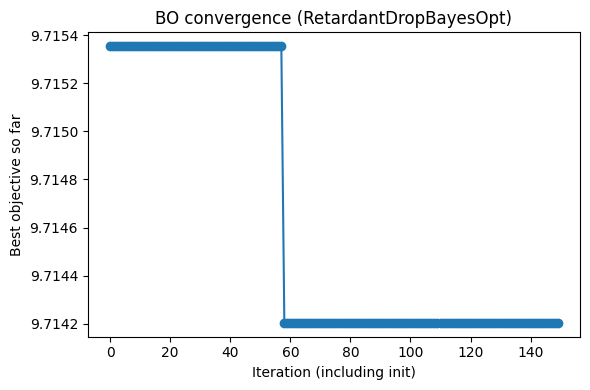

In [12]:
plt.figure(figsize=(6,4))
plt.plot(y_bests, marker='o')
plt.xlabel('Iteration (including init)')
plt.ylabel('Best objective so far')
plt.title('BO convergence (RetardantDropBayesOpt)')
plt.tight_layout()
plt.show()


## 8. Visualise the best solution

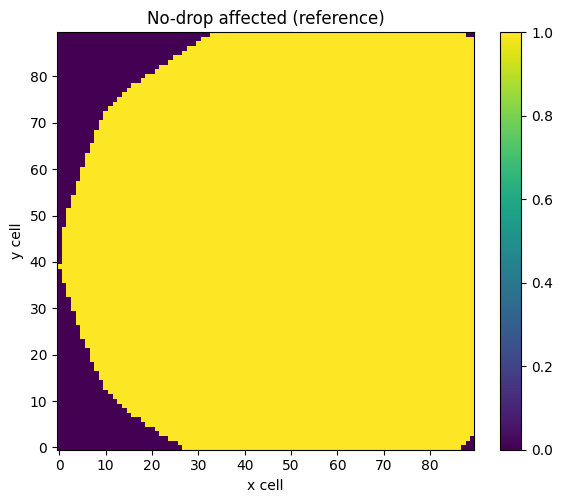

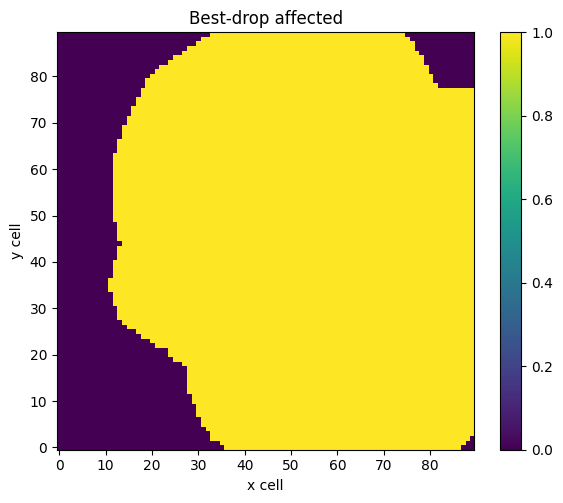

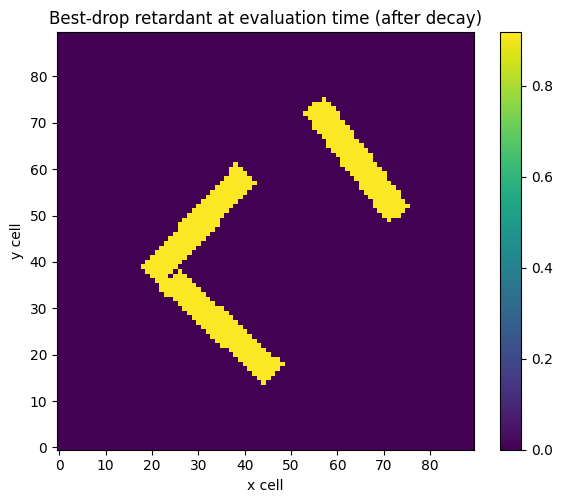

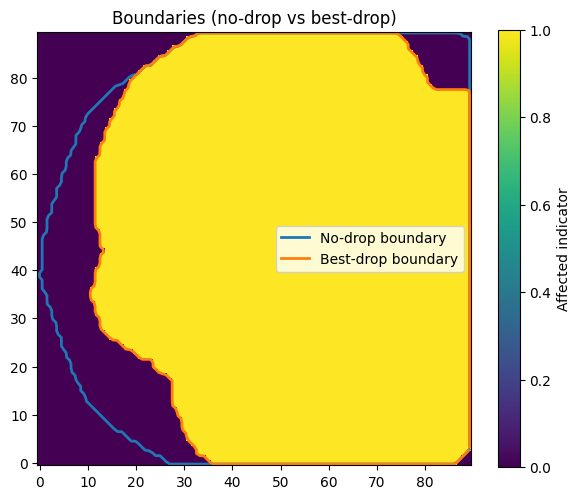

In [11]:
best_state = finsler.simulate_from_firestate(init_state, T=eval_horizon_s, drone_params=best_params)

plot_firestate(state_no_drop, kind="affected", title="No-drop affected (reference)")
plot_firestate(best_state, kind="affected", title="Best-drop affected")
plot_firestate(best_state, kind="retardant", title="Best-drop retardant at evaluation time (after decay)")

# Overlay boundaries for comparison
b0 = finsler.extract_fire_boundary(state_no_drop, K=360, p_boundary=0.5, field="affected")
b1 = finsler.extract_fire_boundary(best_state, K=360, p_boundary=0.5, field="affected")

plt.figure(figsize=(6,5))
field = ((best_state.burning[0] > 0.5) | (best_state.burned[0] > 0.5)).astype(float)
im = plt.imshow(field.T, origin="lower", aspect="equal")
plt.plot(b0.xy[:,0], b0.xy[:,1], linewidth=2, label="No-drop boundary")
plt.plot(b1.xy[:,0], b1.xy[:,1], linewidth=2, label="Best-drop boundary")
plt.legend()
plt.colorbar(im, label="Affected indicator")
plt.title("Boundaries (no-drop vs best-drop)")
plt.tight_layout()
plt.show()
